## Explorative Data Analysis

### Setup

---

In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import numpy as np
import pandas as pd
from scipy import signal

import os
from tqdm import tqdm
import sys
sys.path.insert(0, '../')

from src import utils

In [3]:
DATA_ROOT = os.path.join("..", "data")
NINAPRO_ROOT = os.path.join("..", "data", "ninapro")
SAMPLING_EMG_RATE = 100

### Load Data and Preprocess Data

---

We are using [NinaPro](http://ninaweb.hevs.ch/) dataset for this project. The dataset is available in the `data` folder. The dataset includes sEMG and kinematic data from 27 intact subjects while repeating 52 hand movements plus the rest position. For the scope of this project, we will only use the sEMG data.

The sEMG data were acquired using 10 Otto Bock MyoBock 13E200 electrodes. The dataset includes 10 repetitions of 52 different movements. The subjects are asked to repeat movements which were shown as movies on the screen of a laptop. Each movement repetition lasts 5s and is followed by 3 s of rest. The experiment is divided in three exercises:

1. Basic movements of the fingers.
2. Isometric, isotonic hand configurations and basic wrist movements.
3. Grasping and functional movements.

Therefore, for each exercise, for each subject, the database contains one matlab file with synchronized variables. The variables included in the matlab files are:
- Subject: subject number.
- Exercise: exercise number.
- Emg (10 columns): sEMG signal. Columns 1-8 are the electrodes equally spaced around the forearm at the height of the radio humeral joint. Columns 9 and 10 contain signals from the main activity spot of the muscles flexor and extensor digitorum superficialis.
- Stimulus (1 column): the movement repeated by the subject, according to the displayed movie.
- Restimulus (1 column): the movement repeated by the subject, but with the duration of the movement label refined a-posteriori in order to better correspond to the real movement. 
- Repetition (1 column): repetition of the stimulus.
- Rerepetition (1 column): repetition of restimulus.

Let's start with the overview of the subjects:

In [4]:
subjects = pd.read_csv(os.path.join(NINAPRO_ROOT, "subjects.csv"))
subjects.head()

,Subject,Hand,Handedness,Gender,Age,Height,Weight
0,1,Intact,Right,Male,31,170,75
1,2,Intact,Right,Male,27,170,62
2,3,Intact,Right,Male,22,180,85
3,4,Intact,Right,Male,27,183,95
4,5,Intact,Right,Male,27,178,75


Now, we will pefrom some basic data exploration to get a better understanding of the subjects:

In [5]:
male_n, female_n = subjects.Gender.value_counts()
print(f"ℹ️ There are {male_n} males and {female_n} females in the dataset.")

right, left = subjects['Handedness'].value_counts()
print(f"ℹ️ There are {left} left-handed and {right} right-handed subjects in the dataset.")

pd.DataFrame([subjects['Age'].describe(), subjects['Height'].describe(), subjects['Weight'].describe()])

ℹ️ There are 20 males and 7 females in the dataset.
ℹ️ There are 2 left-handed and 25 right-handed subjects in the dataset.


,count,mean,std,min,25%,50%,75%,max
Age,27.0,28.592593,4.235920,22.0,26.5,28.0,30.0,40.0
Height,27.0,173.148148,8.263468,155.0,167.5,173.0,180.0,185.0
Weight,27.0,69.407407,12.530760,48.0,61.0,67.0,75.5,100.0


To make our life easier, we will parse the data for each exercise into a numpy array in a following fashion:

1. For each subject we load the emg data and corresponding stimulus and repetiion labels. These come as 2D arrays where each row corresponds to a timestamp. Therefore, in each row we will have info about the raw emg signal, stimilus, repetition and subject id.

2. We will then concatenate all the subjects into a single numpy array. In other words, we will stack the 2d arrays on top of each other. This way, we can later choose easily which subjects to use for training and which for testing.

If needed in the later stage, we can also merge the data from all three exercises into a single numpy array. But for the start, it is easier to try training the model for recognizing the movements from each exercise separately.

In [6]:
subject_ids = subjects['Subject'].unique().tolist()
exercise_ids = [1, 2, 3]

for ex in exercise_ids:
    print(f"ℹ️ Parsing exercise {ex}")
    exercise = utils.parse_exercise_data(NINAPRO_ROOT, subject_ids, ex)
    print(f"ℹ️ Exercise {ex} has shape {exercise.shape}")

    save_path = os.path.join(DATA_ROOT, f"exercise_{ex}.npy")
    np.save(save_path, exercise)
    print(f"✅ Successfully saved to {save_path}.\n")

ℹ️ Parsing exercise 1


Loading data for exercise 1:   0%|          | 0/27 [00:00<?, ?it/s]

Loading data for exercise 1: 100%|██████████| 27/27 [00:01<00:00, 14.45it/s]


ℹ️ Exercise 1 has shape (2731393, 13)
✅ Successfully saved to ../data/exercise_1.npy.

ℹ️ Parsing exercise 2


Loading data for exercise 2: 100%|██████████| 27/27 [00:03<00:00,  8.72it/s]


ℹ️ Exercise 2 has shape (3868568, 13)
✅ Successfully saved to ../data/exercise_2.npy.

ℹ️ Parsing exercise 3


Loading data for exercise 3: 100%|██████████| 27/27 [00:04<00:00,  6.08it/s]


ℹ️ Exercise 3 has shape (5953650, 13)
✅ Successfully saved to ../data/exercise_3.npy.



Let's check the sizes of the extracted numpy arrays:

In [7]:
!du -h ../data/exercise_1.npy
!du -h ../data/exercise_2.npy
!du -h ../data/exercise_3.npy

272M	../data/exercise_1.npy
384M	../data/exercise_2.npy
592M	../data/exercise_3.npy


### Exercise Data Inspection

---

Start by loading:

In [8]:
exercises = []
for ex in exercise_ids:
    exercise = np.load(os.path.join(DATA_ROOT, f"exercise_{ex}.npy"))
    print(f"✅ Exercise {ex} loaded, it has {exercise.shape[0]} rows and {exercise.shape[1]} columns.")
    exercises.append(exercise)

✅ Exercise 1 loaded, it has 2731393 rows and 13 columns.
✅ Exercise 2 loaded, it has 3868568 rows and 13 columns.
✅ Exercise 3 loaded, it has 5953650 rows and 13 columns.


Then, let's do some basic data exploration:

In [9]:
total_stimuli = 0
for i, exercise in enumerate(exercises):

    # Number of samples per subject
    samples_per_subject = exercise.shape[0] // len(subject_ids)

    # Number of minutes per subject
    minutes_per_subject = samples_per_subject / SAMPLING_EMG_RATE / 60

    # Number of minutes in total
    minutes_total = minutes_per_subject * len(subject_ids)

    # Unique stimulus and repetitions
    stimuli, rep = exercise[:, 10], exercise[:, 11]
    stimuli_unique = np.unique(stimuli)
    total_stimuli += len(stimuli_unique) - 1 # -1 because 0 is not a stimulus but a rest
    rep_unique = np.unique(rep)
    assert (len(rep_unique) - 1) == 10, "❌ There should be 10 repetitions per stimulus." # -1 because 0 is not a repetition but a rest

    print(f"ℹ️ Exercise {i+1} has {len(subject_ids)} subjects, {samples_per_subject} samples per subject, {minutes_per_subject:.2f} minutes per subject, {minutes_total:.2f} minutes in total, {len(stimuli_unique) - 1} unique stimuli and {len(rep_unique)} unique repetitions.")

assert total_stimuli == 52, "❌There should be 52 unique stimuli in total."
print("✅ There are 52 unique stimuli in total.")
print("✅ Each exercise has 10 repetitions per stimulus.")

ℹ️ Exercise 1 has 27 subjects, 101162 samples per subject, 16.86 minutes per subject, 455.23 minutes in total, 12 unique stimuli and 11 unique repetitions.
ℹ️ Exercise 2 has 27 subjects, 143280 samples per subject, 23.88 minutes per subject, 644.76 minutes in total, 17 unique stimuli and 11 unique repetitions.
ℹ️ Exercise 3 has 27 subjects, 220505 samples per subject, 36.75 minutes per subject, 992.27 minutes in total, 23 unique stimuli and 11 unique repetitions.
✅ There are 52 unique stimuli in total.
✅ Each exercise has 10 repetitions per stimulus.


These numbers are in line with the description of the dataset:
- The exercises last respectively 16, 23, and 31 minutes. Subjects are allowed short breaks between exercises to avoid muscle fatigue, such that the total duration of the experiment is around 100 minutes.
- To reduce variability, the sequence of movements is not randomized in order to induce unconscious movement repetitions into the subjects.

### Exercise Data Preprocessing

---

Based on the following [paper](https://www.nature.com/articles/sdata201453), the data was preprocessed in the following ways:

1. **Synchronization**: high-resolution timestamps were used to synchronize the data streams. Specifically, all streams were super-sampled to the highest sampling frequency (100 Hz) using linear interpolation (real-valued streams)

2. **Relabelling**: The movements performed by the subjects may not perfectly match with the stimuli proposed by our software due to human reaction times and experimental conditions. The resulting erroneous movement labels have been corrected by applying a generalized likelihood ratio algorithm, which realigns the movement boundaries by maximizing the likelihood of a rest-movement-rest sequence. Both the original labels and the new labels are included in the files.

We will perform the following **additional** preprocessing steps:

1. **Bandpass filtering**: we perform the exact same filtering as the authors of the DB1 dataset described in their [paper](https://ieeexplore.ieee.org/document/6825822?arnumber=6825822). Specifically, they low-pass filtered the sEMG signals at a cutoff frequency of `5 Hz` using a zero-phase second-order Butterworth filter. As Atzori et al. argues, the Otto Bock electrodes already applied Root Mean Square filtering which motivated the choice of the loss pass filter. If there was no such filtering, we would likely use more standard `15-450 Hz` bandpass filter.

In [10]:
# Cutoff frequency for low-pass filter
cutoff_frequency = 5

for ex, exercise in enumerate(exercises):
    # Design a zero-phase second-order Butterworth low-pass filter
    sos = signal.butter(N=2, Wn=cutoff_frequency, fs=SAMPLING_EMG_RATE, btype="low", output="sos")
    
    # Apply the filter to the sEMG signal
    EMG = exercise[:, :10]
    EMG = signal.sosfiltfilt(sos, EMG.T).T

    # Save the filtered signal
    save_path = os.path.join(DATA_ROOT, f"exercise_{ex + 1}_emg_processed.npy")
    np.save(save_path, EMG)

print("✅ All exercises filtered and saved.")

✅ All exercises filtered and saved.


### Visualization of the Prepared Data

---

Let's start with visualizing the first exercise data.

In [32]:
# Load the firt exercise
emg1 = np.load(os.path.join(DATA_ROOT, "exercise_1_emg_processed.npy"))
df1 = pd.DataFrame(np.load(os.path.join(DATA_ROOT, "exercise_1.npy"))[:, -3:], columns=["Stimulus", "Repetition", "Subject"], dtype=int)
id2stimulus = {
    0: "Rest",
    1: "Index flexion",
    2: "Index extension",
    3: "Middle flexion",
    4: "Middle extension",
    5: "Ring flexion",
    6: "Ring extension",
    7: "Little flexion",
    8: "Little extension",
    9: "Thumb adduction",
    10: "Thumb abduction",
    11: "Thumb flexion",
    12: "Thumb extension",
}

id2color = {
    0: "gray",
    1: "red",
    2: "lightcoral",    # Lighter shade of red
    3: "green",
    4: "limegreen",     # Lighter shade of green
    5: "blue",
    6: "deepskyblue",   # Lighter shade of blue
    7: "purple",
    8: "mediumpurple",  # Lighter shade of purple
    9: "darkorange",
    10: "orange",   # Lighter shade of orange
    11: "gold",
    12: "khaki",  # Lighter shade of yellow
}

# Choose the subject and obtain the data
subject = 1
df1 = df1[df1["Subject"] == subject]
emg1_subject = emg1[df1.index]

As a recap, Channels 1-8 are the electrodes equally spaced around the forearm at the height of the radio humeral joint. Columns 9 and 10 contain signals from the main activity spot of the muscles flexor and extensor digitorum superficialis. See the figure below for the electrode placement:

![electrode_placement](../figures/electrode_placement.png)

Now, let's see the activity accross the channels.

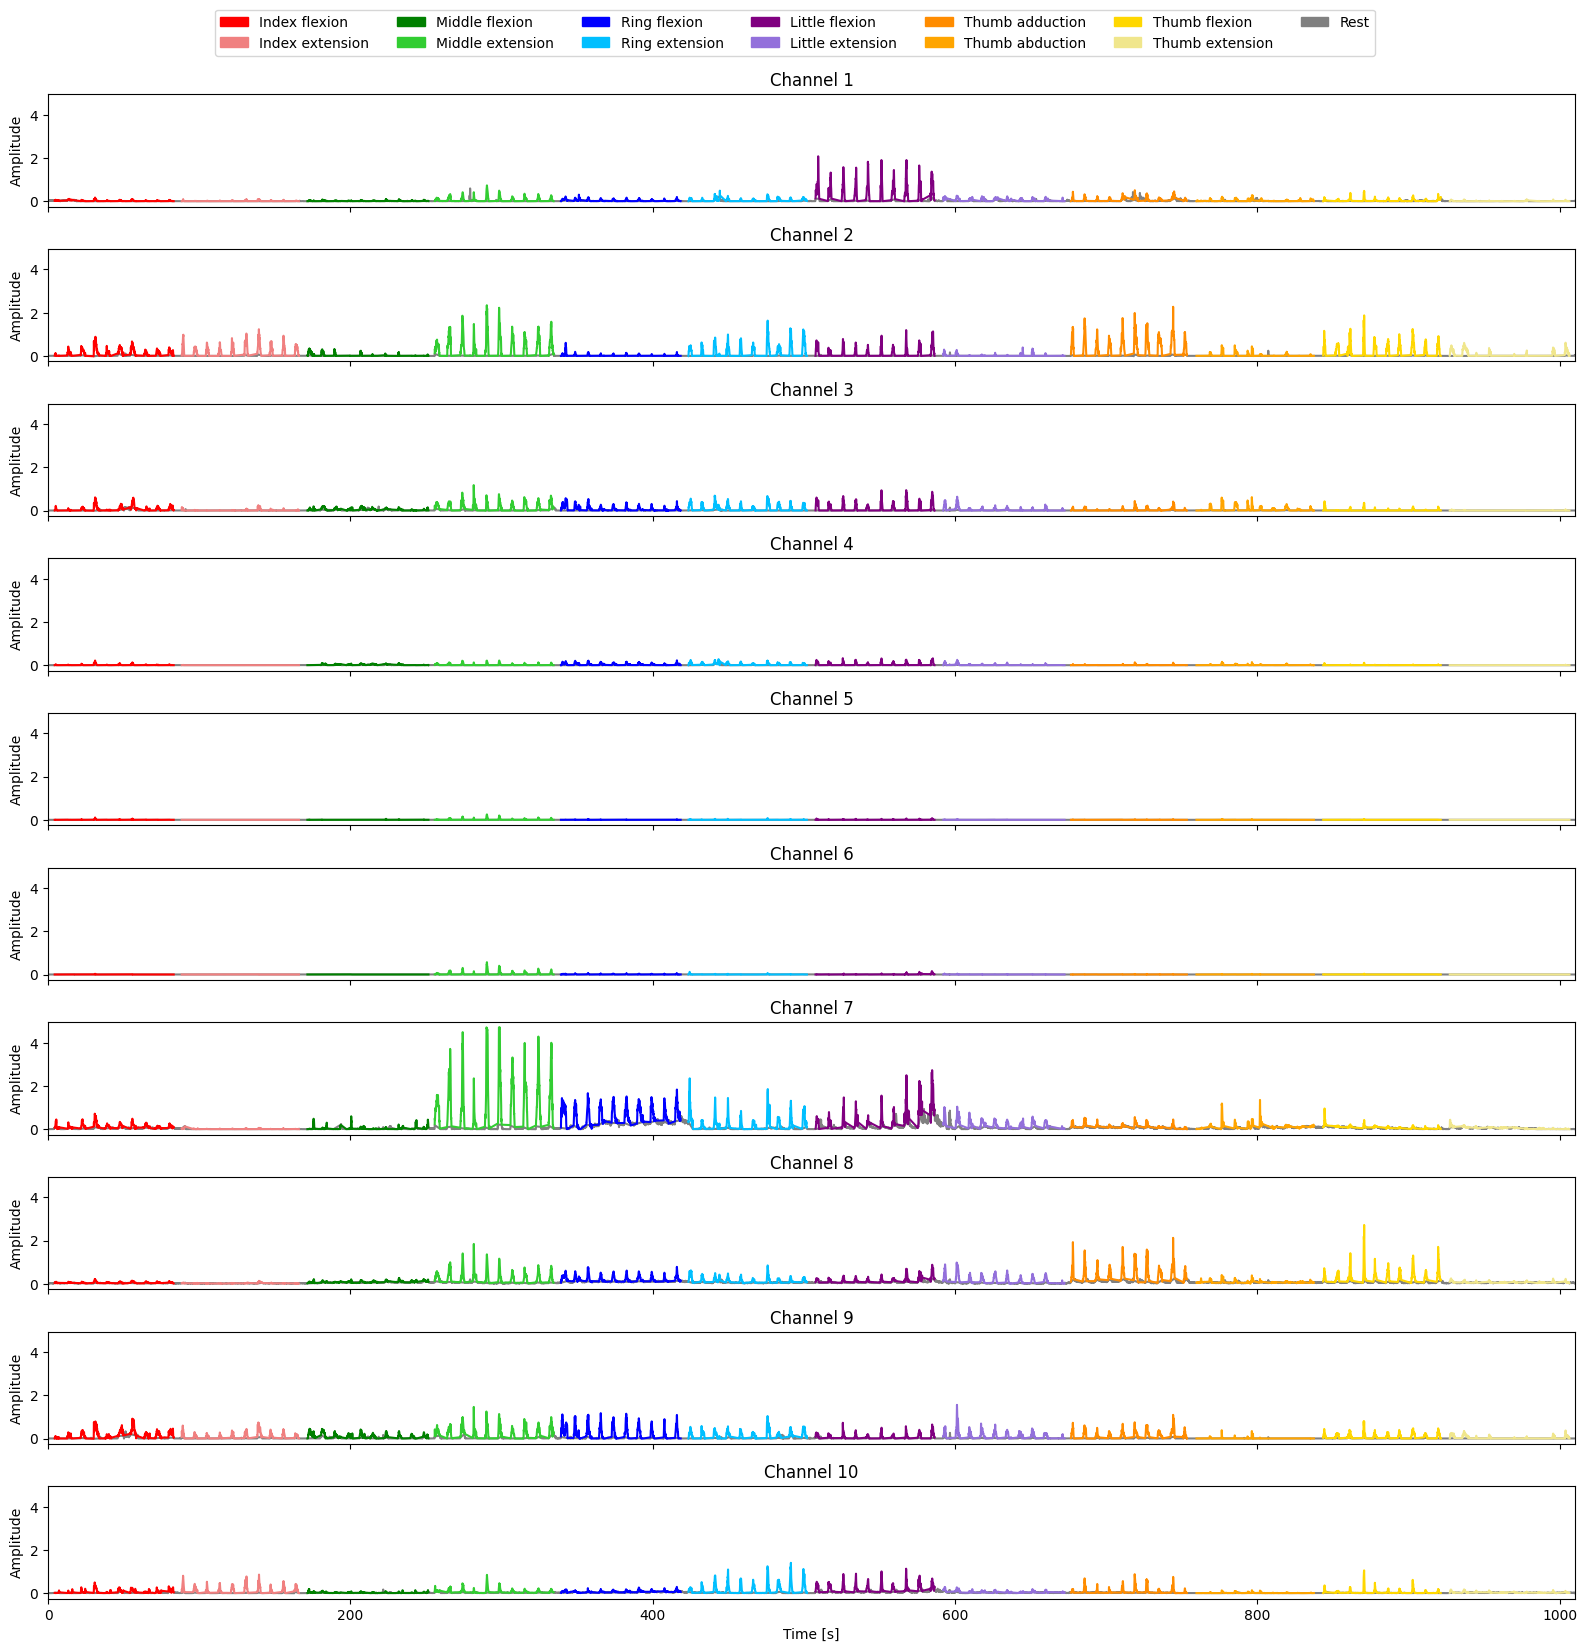

In [36]:
# Setup the plot
n_time, n_channels = emg1_subject.shape
fig,ax = plt.subplots(n_channels, 1, figsize = (16,16), sharex=True, sharey=True)

# Get the time vector
t = np.arange(0, n_time)/SAMPLING_EMG_RATE

# Plot the EMG signal for each channel
for i in range(n_channels):
    sns.lineplot(x=t, y=emg1_subject[:, i], ax=ax[i], hue=df1["Stimulus"], palette=id2color, linewidth=1.5, legend=False)
    ax[i].set_title(f"Channel {i+1}")
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("Amplitude")
    ax[i].set_xlim([0, t[-1]])


# Create a legend for the entire figure based on id2stimulus dictionary
legend_labels = [id2stimulus[i] for i in id2stimulus.keys()][1:] + ["Rest"]
legend_colors = [id2color[i] for i in id2color.keys()][1:] + ["gray"]

ncol = 7  # Number of columns per row
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]

# Place the legend outside the plot
fig.legend(handles=legend_patches, loc='upper center', ncol=ncol, borderaxespad=0.05, bbox_to_anchor=(0.5, 1.03))

plt.tight_layout()
plt.show()


For each channel, we can see 12 stimulus each repeeated 10 times (see the peaks). Interestingly, channels 4 - 6 does not seem to capture any activity relative to the other channels. This plot will be useful when we wll be windowing the data. In particuluar, after windowing, we should make sure that we shuffle the windows.

### Train, Test, Split

---

Start by loading the data again, so we are sure we are using the same data as in the previous section.

In [40]:
emg1 = np.load(os.path.join(DATA_ROOT, "exercise_1_emg_processed.npy"))
df1 = pd.DataFrame(np.load(os.path.join(DATA_ROOT, "exercise_1.npy"))[:, -3:], columns=["Stimulus", "Repetition", "Subject"], dtype=int)
assert df1.shape[0] == emg1.shape[0], "❌ The number of rows in the dataframe and the number of samples in the EMG signal should be the same."
print("✅ The number of rows in the dataframe and the number of samples in the EMG signal are the same.")


✅ The number of rows in the dataframe and the number of samples in the EMG signal are the same.


Define the repetitions that will be assigned to the training, validation and  test sets, and then divide the data accordingly.

In [ ]:
# Define the reps
train_reps = [1, 3, 5, 7, 9]
val_reps = [2, 8]
test_reps = [4, 6, 10]



In [42]:
df1.Repetition.value_counts().sort_index()

Repetition
0     1542153
1      122717
2      121490
3      120834
4      117230
5      118336
6      119118
7      116940
8      117748
9      117007
10     117820
Name: count, dtype: int64